In [111]:
#Import required libraries

import gym
from random import uniform 
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from matplotlib import pyplot as plt

In [112]:
class DQN:

    REPLAY_MEMORY_SIZE = 1000000        # number of tuples in experience replay
    EPSILON = 0.5                       # epsilon of epsilon-greedy exploation
    EPSILON_DECAY = 0.999                # exponential decay multiplier for epsilon
    EPS_STOP = 0.05                     # Stopping criteria for epsilon decay
    HIDDEN1_SIZE = 85                   # size of hidden layer 1
    HIDDEN2_SIZE = 85                   # size of hidden layer 2
    EPISODES_NUM = 2000                 # number of episodes to train on. Ideally shouldn't take longer than 2000
    MAX_STEPS = 500                     # maximum number of steps in an episode
    LEARNING_RATE = 0.0001              # learning rate and other parameters for SGD/RMSProp/Adam
    MINIBATCH_SIZE = 50                 # size of minibatch sampled from the experience replay
    DISCOUNT_FACTOR = 0.99              # MDP's gamma
    TARGET_UPDATE_FREQ = 1000           # number of steps (not episodes) after which to update the target networks
    LAMBDA = 0.001                      # Regularization parameter
    LOG_DIR = './logs'                  # directory wherein logging takes place
    
    # Create and initialize the environment
    def __init__(self, env):
        self.env = gym.make(env)
        self.eps = self.EPSILON
        self.gamma = self.DISCOUNT_FACTOR
        assert len(self.env.observation_space.shape) == 1
        self.input_size = self.env.observation_space.shape[0]      # In case of cartpole, 4 state features
        self.output_size = self.env.action_space.n                 # In case of cartpole, 2 actions (right/left)

    def initialize_network(self):

        # placeholder for the state-space input to the q-network
        self.x = tf.placeholder(tf.float32, [None, self.input_size])

        ############################################################
        # Design your q-network here.
        #
        # Add hidden layers and the output layer. For instance:
        #
        # with tf.name_scope('output'):
        #  W_n = tf.Variable(
        #       tf.truncated_normal([self.HIDDEN_n-1_SIZE, self.output_size],
        #       stddev=0.01), name='W_n')
        #   b_n = tf.Variable(tf.zeros(self.output_size), name='b_n')
        #   self.Q = tf.matmul(h_n-1, W_n) + b_n
        #
        #############################################################

        # Your code here
        self.W1 = tf.Variable(np.random.normal(0, 0.01, size = (self.input_size, self.HIDDEN1_SIZE)), dtype = tf.float32, name = 'W1')
        self.b1 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN1_SIZE)), dtype = tf.float32,name='b1')
        self.W2 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN1_SIZE, self.HIDDEN2_SIZE)), dtype = tf.float32, name='W2')
        self.b2 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN2_SIZE)), dtype = tf.float32,name='b2')
        self.W3 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN2_SIZE, self.output_size)), dtype = tf.float32, name='W3')
        self.b3 = tf.Variable(np.random.normal(0, 0.01, size = (self.output_size)), dtype = tf.float32,name='b3')

        self.Q = tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(self.x, self.W1) + self.b1),self.W2)+self.b2),self.W3)+self.b3

        self.Wt1 = tf.Variable(np.random.normal(0, 0.01, size = (self.input_size, self.HIDDEN1_SIZE)), dtype = tf.float32,name='Wt1')
        self.bt1 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN1_SIZE)), dtype = tf.float32,name='bt1')
        self.Wt2 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN1_SIZE, self.HIDDEN2_SIZE)), dtype = tf.float32,name='Wt2')
        self.bt2 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN2_SIZE)), dtype = tf.float32,name='bt2')
        self.Wt3 = tf.Variable(np.random.normal(0, 0.01, size = (self.HIDDEN2_SIZE, self.output_size)), dtype = tf.float32, name='Wt3')
        self.bt3 = tf.Variable(np.random.normal(0, 0.01, size = (self.output_size)), dtype = tf.float32, name='bt3')

        self.Qt = tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(self.x, self.Wt1) + self.bt1),self.Wt2)+self.bt2),self.Wt3)+self.bt3

        ############################################################
        # Next, compute the loss.
        #
        # First, compute the q-values. Note that you need to calculate these
        # for the actions in the (s,a,s',r) tuples from the experience replay's minibatch
        #
        # Next, compute the l2 loss between these estimated q-values and
        # the target (which is computed using the frozen target network)
        #
        ############################################################

        # Your code here
        self.action = tf.placeholder(tf.int32, [None], name = 'action')
        self.one_hot_action = tf.one_hot(self.action, self.output_size, 1.0, 0.0, name = 'one_hot_action')
        self.Qpred = tf.reduce_sum(tf.multiply(self.Q, self.one_hot_action, name = 'pred'), reduction_indices = [1])
        self.Qexpec = tf.placeholder(tf.float32, [None], name = 'expec')
        self.error = self.Qexpec - self.Qpred
        self.loss = (tf.reduce_mean(tf.square(self.error)) + self.LAMBDA* (tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(tf.nn.l2_loss(self.W3))))
        ############################################################
        # Finally, choose a gradient descent algorithm : SGD/RMSProp/Adam.
        #
        # For instance:
        # optimizer = tf.train.GradientDescentOptimizer(self.LEARNING_RATE)
        # global_step = tf.Variable(0, name='global_step', trainable=False)
        # self.train_op = optimizer.minimize(self.loss, global_step=global_step)
        #
        ############################################################

        # Your code here
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        self.train_op = optimizer.minimize(self.loss, global_step=global_step)
        ############################################################

    def train(self, episodes_num=EPISODES_NUM):

        # Initialize summary for TensorBoard
        summary_writer = tf.summary.FileWriter(self.LOG_DIR)
        summary = tf.Summary()
        # Alternatively, you could use animated real-time plots from matplotlib
        # (https://stackoverflow.com/a/24228275/3284912)

        # Initialize the TF session
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

        ############################################################
        # Initialize other variables (like the replay memory)
        ############################################################

        # Your code here
        replay_buffer = []
        avg_reward = []
        prev100_rewards = []
        tot_steps = 0
        ############################################################
        # Main training loop
        #
        # In each episode,
        #   pick the action for the given state,
        #   perform a 'step' in the environment to get the reward and next state,
        #   update the replay buffer,
        #   sample a random minibatch from the replay buffer,
        #   perform Q-learning,
        #   update the target network, if required.
        #
        #
        #
        # You'll need to write code in various places in the following skeleton
        #
        ############################################################

        for episode in range(episodes_num):

            state = self.env.reset()

            ############################################################
            # Episode-specific initializations go here.
            ############################################################
            #
            # Your code here
            #
            episode_length = 0
            episode_reward = 0.0
            ############################################################

            while True:

                ############################################################
                # Pick the next action using epsilon greedy and and execute it
                ############################################################

                # Your code here
                rand = uniform(0,1)
                if rand < self.eps:
                    action = np.random.choice(2)
                else:
                    action = (self.session.run(self.Q, feed_dict = {self.x: state.reshape(1, state.shape[0])})).argmax()

                # Maintain epsilon constant for 20 steps and then decay
                if (tot_steps % 20 == 0 and self.eps > self.EPS_STOP):
                    self.eps *= self.EPSILON_DECAY
                ############################################################
                # Step in the environment. Something like:
                # next_state, reward, done, _ = self.env.step(action)
                ############################################################

                # Your code here
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                episode_length += 1
                tot_steps += 1

                if (done):
                    if (episode_length < self.MAX_STEPS):
                        reward = reward

                reward -= abs(next_state[0])
                D = [state, action, reward, next_state, done]
                ############################################################
                # Update the (limited) replay buffer.
                #
                # Note : when the replay buffer is full, you'll need to
                # remove an entry to accommodate a new one.
                ############################################################

                # Your code here
                if len(replay_buffer) == self.REPLAY_MEMORY_SIZE:
                    replay_buffer[tot_steps % self.REPLAY_MEMORY_SIZE] = D.copy()
                else:
                    if (len(replay_buffer) == 0):
                        replay_buffer = [D.copy()]
                    else:
                        replay_buffer.append(D.copy())
                ############################################################
                # Sample a random minibatch and perform Q-learning (fetch max Q at s')
                #
                # Remember, the target (r + gamma * max Q) is computed
                # with the help of the target network.
                # Compute this target and pass it to the network for computing
                # and minimizing the loss with the current estimates
                #
                ############################################################

                # Your code here
                if (len(replay_buffer) > self.MINIBATCH_SIZE):
                    mini_batch = np.array(random.sample(replay_buffer, self.MINIBATCH_SIZE))
                    states = np.array([list(state_) for state_ in mini_batch[:, 0]])
                    actions = np.array([action_ for action_ in mini_batch[:, 1]])
                    rewards = np.array([rwd for rwd in mini_batch[:, 2]])
                    next_states = np.array([list(next_state_) for next_state_ in mini_batch[:, 3]])
                    terminal_states = np.array([terminal_state for terminal_state in mini_batch[:, 4]])

                    #Change Qt to Q if you want to remove target network
                    Q_i = np.max(self.session.run(self.Qt, feed_dict = {self.x: next_states}), axis = 1)
                    y_i = np.where(terminal_states, rewards, rewards + self.gamma * Q_i)
                    _, cost = self.session.run([self.train_op, self.loss], feed_dict = {self.x: states, self.Qexpec: y_i, self.action: actions})
                
                ############################################################
                # Update target weights.
                #
                # Something along the lines of:
                # if total_steps % self.TARGET_UPDATE_FREQ == 0:
                #   target_weights = self.session.run(self.weights)
                ############################################################

                # Your code here
                if (tot_steps % self.TARGET_UPDATE_FREQ) == 0:
                    self.session.run(tf.assign(self.Wt1,tf.identity(self.W1)))
                    self.session.run(tf.assign(self.Wt2,tf.identity(self.W2)))
                    self.session.run(tf.assign(self.Wt3,tf.identity(self.W3)))
                    self.session.run(tf.assign(self.bt1,tf.identity(self.b1)))
                    self.session.run(tf.assign(self.bt2,tf.identity(self.b2)))
                    self.session.run(tf.assign(self.bt3,tf.identity(self.b3)))
                    print ("Target network reset")
                ############################################################
                # Break out of the loop if the episode ends
                #
                # Something like:
                # if done or (episode_length == self.MAX_STEPS):
                #   break
                #
                ############################################################

                # Your code here
                state = next_state
                if done:
                    break

            if (len(prev100_rewards) < 100):
                prev100_rewards.append(episode_length)
            else:
                prev100_rewards[episode%100] = episode_length
            avg_reward.append(np.mean(prev100_rewards))

            ############################################################
            # Logging.
            #
            # Very important. This is what gives an idea of how good the current
            # experiment is, and if one should terminate and re-run with new parameters
            # The earlier you learn how to read and visualize experiment logs quickly,
            # the faster you'll be able to prototype and learn.
            #
            # Use any debugging information you think you need.
            # For instance :

            print("Training: Episode = %d, Length = %d, Global step = %d, Average reward = %0.3f" % (episode, episode_length, tot_steps, np.mean(prev100_rewards)))
            summary.value.add(tag="Running average reward (100 episodes)", simple_value= np.mean(prev100_rewards))
            summary_writer.add_summary(summary, episode)

            if (np.min(prev100_rewards) >= 195):
                print ("Task sovled: Avg reward (100ep) has reached 195 ...................")

        return avg_reward
    
    # Simple function to visually 'test' a policy
    def playPolicy(self):

        done = False
        steps = 0
        state = self.env.reset()

        # we assume the CartPole task to be solved if the pole remains upright for 200 steps
        while not done and steps < 200:
            self.env.render()
            q_vals = self.session.run(self.Q, feed_dict={self.x: [state]})
            action = q_vals.argmax()
            state, _, done, _ = self.env.step(action)
            steps += 1

        return steps


In [113]:
#Initialize the DQN network 

dqn = DQN('CartPole-v0')
dqn.initialize_network()

In [114]:
#Training.........might take a few mins
avg_reward = dqn.train(dqn.EPISODES_NUM)

Training: Episode = 0, Length = 14, Global step = 14, Average reward = 14.000
Training: Episode = 1, Length = 9, Global step = 23, Average reward = 11.500
Training: Episode = 2, Length = 12, Global step = 35, Average reward = 11.667
Training: Episode = 3, Length = 11, Global step = 46, Average reward = 11.500
Training: Episode = 4, Length = 14, Global step = 60, Average reward = 12.000
Training: Episode = 5, Length = 16, Global step = 76, Average reward = 12.667
Training: Episode = 6, Length = 13, Global step = 89, Average reward = 12.714
Training: Episode = 7, Length = 12, Global step = 101, Average reward = 12.625
Training: Episode = 8, Length = 14, Global step = 115, Average reward = 12.778
Training: Episode = 9, Length = 15, Global step = 130, Average reward = 13.000
Training: Episode = 10, Length = 10, Global step = 140, Average reward = 12.727
Training: Episode = 11, Length = 18, Global step = 158, Average reward = 13.167
Training: Episode = 12, Length = 14, Global step = 172, Av

Training: Episode = 110, Length = 18, Global step = 1423, Average reward = 12.830
Training: Episode = 111, Length = 10, Global step = 1433, Average reward = 12.750
Training: Episode = 112, Length = 12, Global step = 1445, Average reward = 12.730
Training: Episode = 113, Length = 10, Global step = 1455, Average reward = 12.720
Training: Episode = 114, Length = 14, Global step = 1469, Average reward = 12.720
Training: Episode = 115, Length = 12, Global step = 1481, Average reward = 12.710
Training: Episode = 116, Length = 10, Global step = 1491, Average reward = 12.670
Training: Episode = 117, Length = 10, Global step = 1501, Average reward = 12.670
Training: Episode = 118, Length = 17, Global step = 1518, Average reward = 12.740
Training: Episode = 119, Length = 13, Global step = 1531, Average reward = 12.770
Training: Episode = 120, Length = 13, Global step = 1544, Average reward = 12.750
Training: Episode = 121, Length = 10, Global step = 1554, Average reward = 12.770
Training: Episod

Training: Episode = 210, Length = 14, Global step = 2646, Average reward = 12.230
Training: Episode = 211, Length = 9, Global step = 2655, Average reward = 12.220
Training: Episode = 212, Length = 14, Global step = 2669, Average reward = 12.240
Training: Episode = 213, Length = 14, Global step = 2683, Average reward = 12.280
Training: Episode = 214, Length = 22, Global step = 2705, Average reward = 12.360
Training: Episode = 215, Length = 16, Global step = 2721, Average reward = 12.400
Training: Episode = 216, Length = 14, Global step = 2735, Average reward = 12.440
Training: Episode = 217, Length = 14, Global step = 2749, Average reward = 12.480
Training: Episode = 218, Length = 13, Global step = 2762, Average reward = 12.440
Training: Episode = 219, Length = 11, Global step = 2773, Average reward = 12.420
Training: Episode = 220, Length = 18, Global step = 2791, Average reward = 12.470
Training: Episode = 221, Length = 17, Global step = 2808, Average reward = 12.540
Training: Episode

Target network reset
Training: Episode = 311, Length = 24, Global step = 4007, Average reward = 13.520
Training: Episode = 312, Length = 10, Global step = 4017, Average reward = 13.480
Training: Episode = 313, Length = 9, Global step = 4026, Average reward = 13.430
Training: Episode = 314, Length = 15, Global step = 4041, Average reward = 13.360
Training: Episode = 315, Length = 14, Global step = 4055, Average reward = 13.340
Training: Episode = 316, Length = 14, Global step = 4069, Average reward = 13.340
Training: Episode = 317, Length = 14, Global step = 4083, Average reward = 13.340
Training: Episode = 318, Length = 13, Global step = 4096, Average reward = 13.340
Training: Episode = 319, Length = 14, Global step = 4110, Average reward = 13.370
Training: Episode = 320, Length = 13, Global step = 4123, Average reward = 13.320
Training: Episode = 321, Length = 19, Global step = 4142, Average reward = 13.340
Training: Episode = 322, Length = 11, Global step = 4153, Average reward = 13.

Target network reset
Training: Episode = 411, Length = 98, Global step = 6024, Average reward = 20.170
Training: Episode = 412, Length = 51, Global step = 6075, Average reward = 20.580
Training: Episode = 413, Length = 14, Global step = 6089, Average reward = 20.630
Training: Episode = 414, Length = 12, Global step = 6101, Average reward = 20.600
Training: Episode = 415, Length = 21, Global step = 6122, Average reward = 20.670
Training: Episode = 416, Length = 15, Global step = 6137, Average reward = 20.680
Training: Episode = 417, Length = 20, Global step = 6157, Average reward = 20.740
Training: Episode = 418, Length = 12, Global step = 6169, Average reward = 20.730
Training: Episode = 419, Length = 11, Global step = 6180, Average reward = 20.700
Training: Episode = 420, Length = 44, Global step = 6224, Average reward = 21.010
Training: Episode = 421, Length = 22, Global step = 6246, Average reward = 21.040
Training: Episode = 422, Length = 18, Global step = 6264, Average reward = 21

Training: Episode = 510, Length = 105, Global step = 10389, Average reward = 44.630
Training: Episode = 511, Length = 130, Global step = 10519, Average reward = 44.950
Training: Episode = 512, Length = 46, Global step = 10565, Average reward = 44.900
Training: Episode = 513, Length = 41, Global step = 10606, Average reward = 45.170
Training: Episode = 514, Length = 86, Global step = 10692, Average reward = 45.910
Training: Episode = 515, Length = 50, Global step = 10742, Average reward = 46.200
Training: Episode = 516, Length = 67, Global step = 10809, Average reward = 46.720
Training: Episode = 517, Length = 73, Global step = 10882, Average reward = 47.250
Training: Episode = 518, Length = 22, Global step = 10904, Average reward = 47.350
Training: Episode = 519, Length = 95, Global step = 10999, Average reward = 48.190
Target network reset
Training: Episode = 520, Length = 43, Global step = 11042, Average reward = 48.180
Training: Episode = 521, Length = 78, Global step = 11120, Avera

Training: Episode = 606, Length = 165, Global step = 21484, Average reward = 112.970
Training: Episode = 607, Length = 134, Global step = 21618, Average reward = 114.160
Training: Episode = 608, Length = 184, Global step = 21802, Average reward = 115.810
Training: Episode = 609, Length = 168, Global step = 21970, Average reward = 116.860
Target network reset
Training: Episode = 610, Length = 192, Global step = 22162, Average reward = 117.730
Training: Episode = 611, Length = 186, Global step = 22348, Average reward = 118.290
Training: Episode = 612, Length = 200, Global step = 22548, Average reward = 119.830
Training: Episode = 613, Length = 162, Global step = 22710, Average reward = 121.040
Training: Episode = 614, Length = 168, Global step = 22878, Average reward = 121.860
Target network reset
Training: Episode = 615, Length = 185, Global step = 23063, Average reward = 123.210
Training: Episode = 616, Length = 196, Global step = 23259, Average reward = 124.500
Training: Episode = 617

Training: Episode = 699, Length = 200, Global step = 37272, Average reward = 170.150
Training: Episode = 700, Length = 200, Global step = 37472, Average reward = 170.150
Training: Episode = 701, Length = 200, Global step = 37672, Average reward = 170.320
Training: Episode = 702, Length = 200, Global step = 37872, Average reward = 170.470
Target network reset
Training: Episode = 703, Length = 200, Global step = 38072, Average reward = 170.830
Training: Episode = 704, Length = 200, Global step = 38272, Average reward = 171.110
Training: Episode = 705, Length = 200, Global step = 38472, Average reward = 171.530
Training: Episode = 706, Length = 200, Global step = 38672, Average reward = 171.880
Training: Episode = 707, Length = 200, Global step = 38872, Average reward = 172.540
Target network reset
Training: Episode = 708, Length = 200, Global step = 39072, Average reward = 172.700
Training: Episode = 709, Length = 200, Global step = 39272, Average reward = 173.020
Training: Episode = 710

Training: Episode = 789, Length = 200, Global step = 55272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 790, Length = 200, Global step = 55472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 791, Length = 200, Global step = 55672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 792, Length = 200, Global step = 55872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 793, Length = 200, Global step = 56072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 794, Length = 200, Global step = 56272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 795, Length = 200, Global step = 56472, A

Training: Episode = 842, Length = 200, Global step = 65872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 843, Length = 200, Global step = 66072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 844, Length = 200, Global step = 66272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 845, Length = 200, Global step = 66472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 846, Length = 200, Global step = 66672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 847, Length = 200, Global step = 66872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 848, Length = 200, G

Training: Episode = 895, Length = 200, Global step = 76472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 896, Length = 200, Global step = 76672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 897, Length = 200, Global step = 76872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 898, Length = 200, Global step = 77072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 899, Length = 200, Global step = 77272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 900, Length = 200, Global step = 77472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 901, Length = 200, Global step = 77672, A

Target network reset
Training: Episode = 948, Length = 200, Global step = 87072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 949, Length = 200, Global step = 87272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 950, Length = 200, Global step = 87472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 951, Length = 200, Global step = 87672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 952, Length = 200, Global step = 87872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 953, Length = 200, Global step = 88072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 954, Length = 200, G

Training: Episode = 1001, Length = 200, Global step = 97672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1002, Length = 200, Global step = 97872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1003, Length = 200, Global step = 98072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1004, Length = 200, Global step = 98272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1005, Length = 200, Global step = 98472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1006, Length = 200, Global step = 98672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1007, Length = 200, Global step = 9

Target network reset
Training: Episode = 1053, Length = 200, Global step = 108072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1054, Length = 200, Global step = 108272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1055, Length = 200, Global step = 108472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1056, Length = 200, Global step = 108672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1057, Length = 200, Global step = 108872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1058, Length = 200, Global step = 109072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1059, Le

Training: Episode = 1105, Length = 200, Global step = 118472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1106, Length = 200, Global step = 118672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1107, Length = 200, Global step = 118872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1108, Length = 200, Global step = 119072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1109, Length = 200, Global step = 119272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1110, Length = 200, Global step = 119472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1111, Length = 200, Global st

Training: Episode = 1157, Length = 200, Global step = 128872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1158, Length = 200, Global step = 129072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1159, Length = 200, Global step = 129272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1160, Length = 200, Global step = 129472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1161, Length = 200, Global step = 129672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1162, Length = 200, Global step = 129872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1163, Le

Training: Episode = 1209, Length = 200, Global step = 139272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1210, Length = 200, Global step = 139472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1211, Length = 200, Global step = 139672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1212, Length = 200, Global step = 139872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1213, Length = 200, Global step = 140072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1214, Length = 200, Global step = 140272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1215, Length = 200, Global st

Training: Episode = 1261, Length = 200, Global step = 149672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1262, Length = 200, Global step = 149872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1263, Length = 200, Global step = 150072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1264, Length = 200, Global step = 150272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1265, Length = 200, Global step = 150472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1266, Length = 200, Global step = 150672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1267, Length = 200, Global st

Target network reset
Training: Episode = 1313, Length = 200, Global step = 160072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1314, Length = 200, Global step = 160272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1315, Length = 200, Global step = 160472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1316, Length = 200, Global step = 160672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1317, Length = 200, Global step = 160872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1318, Length = 200, Global step = 161072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1319, Le

Training: Episode = 1365, Length = 200, Global step = 170472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1366, Length = 200, Global step = 170672, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1367, Length = 200, Global step = 170872, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1368, Length = 200, Global step = 171072, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1369, Length = 200, Global step = 171272, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1370, Length = 200, Global step = 171472, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1371, Length = 200, Global st

Training: Episode = 1427, Length = 200, Global step = 182733, Average reward = 198.610
Training: Episode = 1428, Length = 200, Global step = 182933, Average reward = 198.610
Target network reset
Training: Episode = 1429, Length = 200, Global step = 183133, Average reward = 198.610
Training: Episode = 1430, Length = 200, Global step = 183333, Average reward = 198.610
Training: Episode = 1431, Length = 200, Global step = 183533, Average reward = 198.610
Training: Episode = 1432, Length = 200, Global step = 183733, Average reward = 198.610
Training: Episode = 1433, Length = 200, Global step = 183933, Average reward = 198.610
Target network reset
Training: Episode = 1434, Length = 200, Global step = 184133, Average reward = 198.610
Training: Episode = 1435, Length = 200, Global step = 184333, Average reward = 198.610
Training: Episode = 1436, Length = 200, Global step = 184533, Average reward = 198.610
Training: Episode = 1437, Length = 200, Global step = 184733, Average reward = 198.610
T

Training: Episode = 1517, Length = 200, Global step = 200674, Average reward = 199.210
Training: Episode = 1518, Length = 200, Global step = 200874, Average reward = 199.210
Target network reset
Training: Episode = 1519, Length = 200, Global step = 201074, Average reward = 199.210
Training: Episode = 1520, Length = 200, Global step = 201274, Average reward = 199.210
Training: Episode = 1521, Length = 200, Global step = 201474, Average reward = 199.410
Training: Episode = 1522, Length = 200, Global step = 201674, Average reward = 199.410
Training: Episode = 1523, Length = 200, Global step = 201874, Average reward = 199.410
Target network reset
Training: Episode = 1524, Length = 200, Global step = 202074, Average reward = 199.410
Training: Episode = 1525, Length = 200, Global step = 202274, Average reward = 199.410
Training: Episode = 1526, Length = 200, Global step = 202474, Average reward = 199.410
Training: Episode = 1527, Length = 200, Global step = 202674, Average reward = 199.410
T

Training: Episode = 1592, Length = 200, Global step = 215674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1593, Length = 200, Global step = 215874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1594, Length = 200, Global step = 216074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1595, Length = 200, Global step = 216274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1596, Length = 200, Global step = 216474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1597, Length = 200, Global step = 216674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1598, Length = 200, Global st

Target network reset
Training: Episode = 1644, Length = 200, Global step = 226074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1645, Length = 200, Global step = 226274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1646, Length = 200, Global step = 226474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1647, Length = 200, Global step = 226674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1648, Length = 200, Global step = 226874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1649, Length = 200, Global step = 227074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1650, Le

Training: Episode = 1696, Length = 200, Global step = 236474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1697, Length = 200, Global step = 236674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1698, Length = 200, Global step = 236874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1699, Length = 200, Global step = 237074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1700, Length = 200, Global step = 237274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1701, Length = 200, Global step = 237474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1702, Length = 200, Global st

Training: Episode = 1748, Length = 200, Global step = 246874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1749, Length = 200, Global step = 247074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1750, Length = 200, Global step = 247274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1751, Length = 200, Global step = 247474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1752, Length = 200, Global step = 247674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1753, Length = 200, Global step = 247874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1754, Le

Training: Episode = 1800, Length = 200, Global step = 257274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1801, Length = 200, Global step = 257474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1802, Length = 200, Global step = 257674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1803, Length = 200, Global step = 257874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1804, Length = 200, Global step = 258074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1805, Length = 200, Global step = 258274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1806, Length = 200, Global st

Training: Episode = 1852, Length = 200, Global step = 267674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1853, Length = 200, Global step = 267874, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1854, Length = 200, Global step = 268074, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1855, Length = 200, Global step = 268274, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1856, Length = 200, Global step = 268474, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1857, Length = 200, Global step = 268674, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Training: Episode = 1858, Length = 200, Global st

Training: Episode = 1928, Length = 200, Global step = 282846, Average reward = 199.720
Target network reset
Training: Episode = 1929, Length = 200, Global step = 283046, Average reward = 199.720
Training: Episode = 1930, Length = 200, Global step = 283246, Average reward = 199.720
Training: Episode = 1931, Length = 200, Global step = 283446, Average reward = 199.720
Training: Episode = 1932, Length = 200, Global step = 283646, Average reward = 199.720
Training: Episode = 1933, Length = 200, Global step = 283846, Average reward = 199.720
Target network reset
Training: Episode = 1934, Length = 200, Global step = 284046, Average reward = 199.720
Training: Episode = 1935, Length = 200, Global step = 284246, Average reward = 199.720
Training: Episode = 1936, Length = 200, Global step = 284446, Average reward = 199.720
Training: Episode = 1937, Length = 200, Global step = 284646, Average reward = 199.720
Training: Episode = 1938, Length = 200, Global step = 284846, Average reward = 199.720
T

Training: Episode = 1998, Length = 200, Global step = 296846, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................
Target network reset
Training: Episode = 1999, Length = 200, Global step = 297046, Average reward = 200.000
Task sovled: Avg reward (100ep) has reached 195 ...................


In [116]:
#Visualize the learned behaviour for a few episodes

results = []
for i in range(50):
        episode_length = dqn.playPolicy()
        print("Test steps = ", episode_length)
        results.append(episode_length)
        print("Mean steps = ", sum(results) / len(results))

Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =  200
Mean steps =  200.0
Test steps =

In [117]:
#Closing the session

dqn.env.close()

Text(0.5, 1.0, 'Reward Evolution')

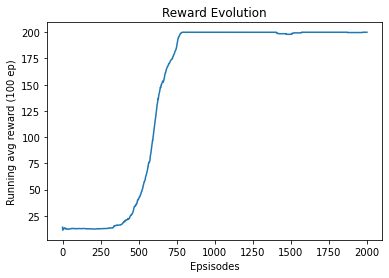

In [119]:
#Plotting

plt.plot(avg_reward)
plt.xlabel("Epsisodes")
plt.ylabel("Running avg reward (100 ep)")
plt.title("Reward Evolution")